In [2]:
from brian2 import *
%matplotlib inline

Define a barebones model.

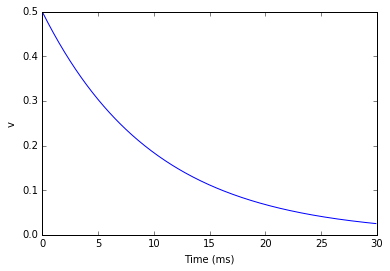

In [2]:
start_scope()

tau = 10*ms

eqs = '''
dv/dt = -v / tau : 1
'''

# solution is: 0.5 * exp(-t / tau)

G = NeuronGroup(1, eqs, method='linear')
statemon = StateMonitor(G, 'v', record=True)

G.v = 0.5

run(30*ms)

plot(statemon.t/ms, statemon.v[0])
xlabel('Time (ms)')
ylabel('v')

Neuron starts with membrane potential of 0.5 and has so driving current (just how the voltage changes over time, which is negative from its differential equation). Converges to zero as no driving current. 

Lets define a more complex model with a driving current (IR). 

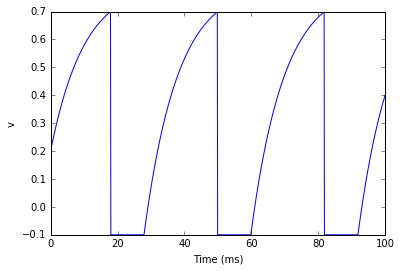

In [4]:
start_scope()

tau = 10*ms

eqs = '''
dv/dt = (IR - v) / tau : 1 (unless refractory)
IR = 0.8 : 1
'''

G = NeuronGroup(1, eqs, method='linear', threshold='v>0.7', reset='v=-0.1', refractory=10*ms)
statemon = StateMonitor(G, 'v', record=True)

G.v = 0.2
#G.IR = ''

run(100*ms)

plot(statemon.t/ms, statemon.v[0])
xlabel('Time (ms)')
ylabel('v')


This new model starts at a low membrane voltage (0.2) but is driven by a current of 0.8 (IR). Neuron Spikes when it hits the threshold of 0.7 and is reset to -0.1. After spiking the neuron stays refractory for 15ms before starting to charge again. 

Now lets make the neurons fire probabilistically.

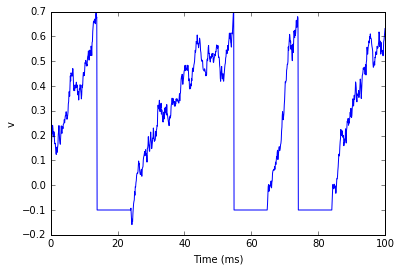

In [5]:
start_scope()

tau = 10*ms
sigma = 0.2

eqs = '''
dv/dt = (IR - v) / tau + sigma*xi*tau**-0.5 : 1 (unless refractory)
IR = 0.8 : 1
'''

G = NeuronGroup(1, eqs, method='euler', threshold='v>0.7', reset='v=-0.1', refractory=10*ms)
statemon = StateMonitor(G, 'v', record=True)

G.v = 0.2
#G.IR = ''

run(100*ms)

plot(statemon.t/ms, statemon.v[0])
xlabel('Time (ms)')
ylabel('v')


Firing times are now affected. More work to be done into the exact mechanics of the introduced noise but useful example for now.

Last example from tutorial:

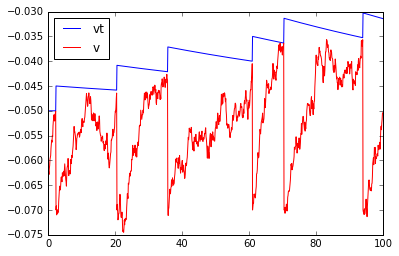

In [6]:
start_scope()

N = 10
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

eqs = '''
dv/dt = (v_drive + vr - v) / tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0 - vt) / tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)
n0 = StateMonitor(G, 'v', record=0)
vtm = StateMonitor(G, 'vt', record=0)

G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

#_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
#xlabel('Time (ms)')
#ylabel('Instantaneous firing rate (sp/s)');
plot(vtm.t/ms, vtm.vt[0], '-b', label='vt')
plot(n0.t/ms, n0.v[0], '-r', label='v')
legend(loc='best');

It looks like vt (the threshold) changes with the neuron spiking. When a neuron spikes the threshold increases making it harder for the neuron to spike again. This also has a refractory period though and if the neuron isn't spiking it returns to its original state. 

Try playing with the values of tau_t (thresholds refractory rate), tau (neurons refractory rate) and v_drive (the driving current). 

Lets make some synapses...

WARNING    "tau" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


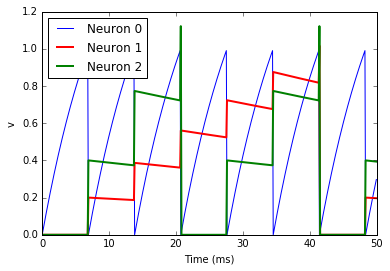

In [7]:
start_scope()

eqs = '''
#dv/dt = (I-v)/tau + xi*tau**-0.5: 1 # For more fun if you like it messy
dv/dt = (I-v)/tau : 1  # or if you just want it nice
I : 1
tau : second
'''

N = 3
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')  # Synapse has a variable w (weight)
S.connect(i=0, j=[1, 2])                           # Feed 1 into next two
S.w = 'j*0.2'                                      # neuron [1, 2] have weights [0.2, 0.4]

#Uncomment if you want to look at the delay (makes graph messy)
#S.delay = 'j*2*ms'                                 # Can introduce a delay between pre and post 

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-r', lw=2, label='Neuron 1')
plot(M.t/ms, M.v[2], '-g', lw=2, label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

Here we can see how neuron 0 spikes frequently increase the membrane potential of neuron 1 and 2 until eventually they also spike. Neuron 1 and 2 receieve different amounts of stimulation from neuron 0 based on their weights (0.2 and 0.4). (neuron 2 is much more excited by 0 than 1 is). This is great, we can now connect neurons together with a delay. 

Now lets create ourselves a helper function for more complex connectivities

In [8]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [9]:
def visualise_connectivity(S):
    """ Take a synapse and visualse the connectivity
    """
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)  # Plot dots on the 
    
    
    
















BELOW IS PLAY CODE TO LOAD AER 





















In [10]:
import os

In [11]:
start_scope()

def load_aer(filename, 
             check_sorted = False, 
             reinit_time = False):
    '''
    Loads Address Event Representation (AER) data files for use in
    Brian. Files contain spikes as a binary representation of an
    ``address`` (i.e. neuron identifier) and a timestamp.

    This function returns two arrays, an array of addresses (neuron indices) and an array of spike times (in second).

    Note: For index files (that point to multiple .(ae)dat files, typically aeidx files) it
    will return a list containing tuples (addr, time) as for single files.
    
    Usage:
    
    ids, times = load_aer('/path/to/file.aedat')
    
    Keyword Arguments:

    ``reinit_time`` If True, sets the first spike time to zero and all others relative to that one.
    
    ``check_sorted`` If True, checks if timestamps are sorted, and sorts them if necessary.
    
    Example use:
    
    To use the spikes recorded in the AER file ``filename`` in a Brian ``NeuronGroup``, one should do:

    addr, timestamp =  load_AER(filename, reinit_time = True)
    G = AERSpikeGeneratorGroup((addr, timestamps))

    An example script can be found in examples/misc/spikes_io.py

    
    '''
    # This loading fun is inspired by the following Matlab script:
    # http://jaer.svn.sourceforge.net/viewvc/jaer/trunk/host/matlab/loadaerdat.m?revision=2001&content-type=text%2Fplain
    
    
    # Figure out extension, check filename, ...
    l = filename.split('.')
    ext = l[-1].strip('\n')
    filename = filename.strip('\n')
    directory = os.path.dirname(filename)
    
    if ext == 'aeidx':
        #AER data points to different AER files
        return load_multiple_AER(filename, 
                                 check_sorted = check_sorted, 
                                 relative_time = reinit_time, 
                                 directory = directory)
    elif not (ext == 'dat' or ext == 'aedat'):
        raise ValueError('Wrong extension for AER data, should be dat, or aedat, it was '+ext)
    
    f=open(filename,'rb')

    # Load the encoding parameters
    # version of AER
    version=1 # default (if not found in the file)
    # value of dt
    dt = 1e-6 # default (if not found in the file)
    
    # skip header and look overrident values for dt/version
    line = f.readline().decode("utf-8") 
    while len(line) == 0 or line[0] == '#':
        if line[:9] == "#!AER-DAT":
            version = int(float(line[9:-1]))
        if line[:21] == '# Timestamps tick is ':
            dt = eval(line[21:].split()[0])
#            print 'recognized dt = %.4f second' % dt
        try:
            line = f.readline()
            line = line.decode("utf-8")
        except:
            break
    line += f.read()
    f.close()
    # Load the files
    if version==1:
        '''
        Format is: sequence of (addr = 2 bytes,timestamp = 4 bytes)
        Number format is big endian ('>')
        '''
        ## This commented paragraph is the non-vectorized version
        #nevents=len(line)/6
        #for n in range(nevents):
        #    events.append(unpack('>HI',line[n*6:(n+1)*6])) # address,timestamp
        x=np.fromstring(line, dtype=np.int16) # or uint16?
        x=x.reshape((len(x)/3,3))
        addr=x[:,0].newbyteorder('>')
        timestamp=x[:,1:].copy()
        timestamp.dtype=int32
        timestamp=timestamp.newbyteorder('>').flatten()
    else: # i.e. version==2
        '''
        Format is: sequence of (addr = 4 bytes,timestamp = 4 bytes)
        Number format is big endian ('>')
        '''
        ## This commented paragraph is the non-vectorized version
        #nevents=len(line)/8
        #for n in range(nevents):
        #    events.append(unpack('>II',line[n*8:(n+1)*8])) # address,timestamp
        print(1)
        x = np.fromstring(line, dtype=np.int32).newbyteorder('>')
        addr = x[::2]
        if len(addr) == len(x[1::2]):
            timestamp = x[1::2]
        else:
            # alternative fallback:
            #timestamp = x[1::2]
            #print len(x)
            raise IOError("""Corrupted AER file, timestamps and addresses don't have the same lengths.""")
    print(2)
    # Sorts the events if necessary
    if check_sorted: 
        if any(np.diff(timestamp)<0): # not sorted
            ind = np.argsort(timestamp)
            addr,timestamp = addr[ind],timestamp[ind]
    print(3)
    # Set first spike time to 0 if required
    if reinit_time:
        t0 = min(timestamp)
        timestamp -= t0
    print(4)
    # Check for negative timestamps (i dont remember why?)
    if (timestamp<0).all():
        raise ValueError("""AER file contains (only!) negative timestamps, \
consider using reinit_time = True""")
    
    return addr, timestamp * dt


In [4]:
import struct
import os

V3 = "aedat3"
V2 = "aedat"  # current 32bit file format
V1 = "dat"  # old format

EVT_DVS = 0  # DVS event type
EVT_APS = 1  # APS event


def loadaerdat(datafile='/tmp/aerout.dat', length=0, version=V2, debug=1, camera='DVS128'):
    """    
    load AER data file and parse these properties of AE events:
    - timestamps (in us), 
    - x,y-position [0..127]
    - polarity (0/1)

    @param datafile - path to the file to read
    @param length - how many bytes(B) should be read; default 0=whole file
    @param version - which file format version is used: "aedat" = v2, "dat" = v1 (old)
    @param debug - 0 = silent, 1 (default) = print summary, >=2 = print all debug
    @param camera='DVS128' or 'DAVIS240'
    @return (ts, xpos, ypos, pol) 4-tuple of lists containing data of all events;
    """
    # constants
    aeLen = 8  # 1 AE event takes 8 bytes
    readMode = '>II'  # struct.unpack(), 2x ulong, 4B+4B
    td = 0.000001  # timestep is 1us   
    if(camera == 'DVS128'):
        xmask = 0x00fe
        xshift = 1
        ymask = 0x7f00
        yshift = 8
        pmask = 0x1
        pshift = 0
    elif(camera == 'DAVIS240'):  # values take from scripts/matlab/getDVS*.m
        xmask = 0x003ff000
        xshift = 12
        ymask = 0x7fc00000
        yshift = 22
        pmask = 0x800
        pshift = 11
        eventtypeshift = 31
    else:
        raise ValueError("Unsupported camera: %s" % (camera))

    if (version == V1):
        print ("using the old .dat format")
        aeLen = 6
        readMode = '>HI'  # ushot, ulong = 2B+4B

    aerdatafh = open(datafile, 'rb')
    k = 0  # line number
    p = 0  # pointer, position on bytes
    statinfo = os.stat(datafile)
    if length == 0:
        length = statinfo.st_size    
    print ("file size", length)
    
    # header
    lt = aerdatafh.readline().decode('utf-8')
    while lt and lt[0] == "#":
        p += len(lt)
        k += 1
        lt = aerdatafh.readline().decode('utf-8') 
        if lt.startswith('#End of Preferences'):
            p += len(lt)   # TODO this is a bit lazy, rearrange logic
            k += 1
            break
        if debug >= 2:
            #print (str(lt))
            pass
        continue
    
    # variables to parse
    timestamps = []
    xaddr = []
    yaddr = []
    pol = []
    
    # read data-part of file
    aerdatafh.seek(p)
    s = aerdatafh.read(aeLen)
    p += aeLen
    length += p
    
    #print (xmask, xshift, ymask, yshift, pmask, pshift, aeLen,  p, length)    
    while p < length:
        #print (xmask, xshift, ymask, yshift, pmask, pshift, aeLen,  p, length)
        #ii = int.from_bytes(s, byteorder='big')
        #print(str(bin(ii)), len(str(bin(ii))))
        #print(type(s))
        addr, ts = struct.unpack(readMode, s)
        
        # parse event type
        if(camera == 'DAVIS240'):
            eventtype = (addr >> eventtypeshift)
        else:  # DVS128
            eventtype = EVT_DVS
        
        # parse event's data
        if(eventtype == EVT_DVS):  # this is a DVS event
            #print(str(bin(addr)), len(str(bin(addr))))
            x_addr = (addr & xmask) >> xshift
            y_addr = (addr & ymask) >> yshift
            a_pol = (addr & pmask) >> pshift


            if debug >= 3: 
                print("ts->", ts)  # ok
                print("x-> ", x_addr)
                print("y-> ", y_addr)
                print("pol->", a_pol)

            timestamps.append(ts)
            xaddr.append(x_addr)
            yaddr.append(y_addr)
            pol.append(a_pol)
            #poldf
        
        aerdatafh.seek(p)
        s = aerdatafh.read(aeLen)
        p += aeLen        

    if debug > 0:
        print(len(timestamps))
        try:
            print ("read %i (~ %.2fM) AE events, duration= %.2fs" % (len(timestamps), len(timestamps) / float(10 ** 6), (timestamps[-1] - timestamps[0]) * td))
            n = 5
            print ("showing first %i:" % (n))
            print ("timestamps: %s \nX-addr: %s\nY-addr: %s\npolarity: %s" % (timestamps[0:n], xaddr[0:n], yaddr[0:n], pol[0:n]))
        except Exception as e:
            print(e)
            print ("failed to print statistics")

    return timestamps, xaddr, yaddr, pol

In [58]:
#addr, ts = load_aer('M1a_expand.aedat', reinit_time = True)
#print(len(ts))
#print('-'*30)
#ts, xs, ys, ps = loadaerdat(datafile='/media/data/DAVISMeetsRat/r4.aedat', length=0, version='aedat', debug=1, camera='DAVIS240')
ts, xs, ys, ps = loadaerdat(datafile='M1a_expand.aedat', length=30000, version='aedat', debug=1, camera='DVS128')
print(len(ts))

file size 30000
3750
read 3750 (~ 0.00M) AE events, duration= 0.05s
showing first 5:
timestamps: [1686759553, 1686759579, 1686759585, 1686759586, 1686759587] 
X-addr: [102, 51, 120, 120, 120]
Y-addr: [49, 4, 61, 61, 61]
polarity: [0, 1, 1, 1, 1]
3750


In [74]:
max(xs)
v = (3, 5)
print(*v)
l = [x for x in zip([1,2,3], [4, 5, 6])]
print(l)
ttt = [3, 5, 7]*us
print(ttt)

3 5
[(1, 4), (2, 5), (3, 6)]
[ 3.  5.  7.] us


52.205


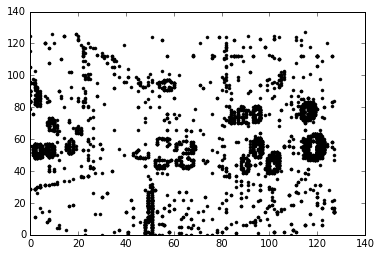

In [59]:
plot(xs, ys, '.k')
print((ts[-1] - ts[1])/1000)

file size 30000


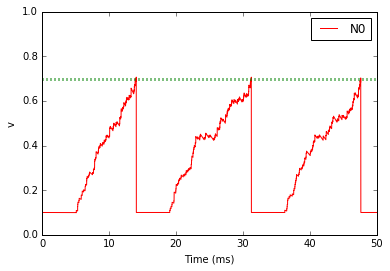

In [207]:
start_scope()

# Need to adjust the simulation dt since these are small times
defaultclock.dt = 1*us

N = 1               # All inputs feed to 1 neuron
tau = 10*ms
eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''

RESX = 128
RESY = 128
RES = RESX * RESY

##      Some helpful functions
flatIndex = lambda x, y : y*RESX + x
squareIndex = lambda i : (i % 128, int(i / 128))  # TODO there is probably some math todo for DAVIS 

## LOAD REAL DATA
file = 'M1a_expand.aedat'
bytes2read = 30000
ts, xs, ys, ps = loadaerdat(datafile=file, length=bytes2read, version='aedat', debug=0, camera='DVS128')

##      PROCESS DATA FROM 2D to 1D and filter duplicate spikes at a single time
# TODO This means no 2 neurons can fire at the same us.... Needs a fix
real_indices = [flatIndex(*xy) for xy in zip(xs, ys)]
real_times, uniq_idxs = np.unique(ts, return_index=True)
real_indices = np.asarray(real_indices)[uniq_idxs]
real_times = (real_times - real_times[0])*us

##      This is the new input layer based on the real data
inp = SpikeGeneratorGroup(RES, real_indices, real_times)

G = NeuronGroup(N, eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
S = Synapses(inp, G, 'w : 1', on_pre='v_post += w')
S.connect(p=0.15)

S.w = 0.01
G.v = 1

voltMon = StateMonitor(G, 'v', record=True)


###############      RUN AND PLOT    ###############
run(50*ms)

for n in range(N):
    plot(voltMon.t/ms, voltMon.v[0], '-r', label='N'+str(n))
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')


We have successfully imported AER data and created a SpikeGeneratorGroup that lets the data interface to Brian! The default timestep for the simulation was made smaller to ensure there were no timing problems. Some Constants and helper functions were created to help preprocess the data. Real data is messy and had some pixels spiking multiple times for a given time point so these were cleaned up using unique. 
The way unique is currently used means no two pixels can fire during the same us which isn't correct. Need to corrolate between same us AND same (x,y) location. 

Lets create a spiking network with multiple neurons which spatially sample from the DVS data.

file size 30000


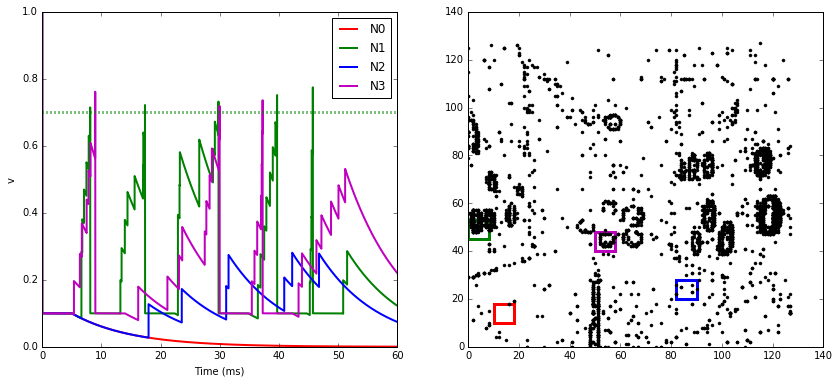

In [5]:
start_scope()

defaultclock.dt = 1*us
RESX = 128
RESY = 128
RES = RESX * RESY
N = 4                           # We will have 4 neurons       
tau = 10*ms
eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''
flatIndex = lambda x, y : y*RESX + x
squareIndex = lambda i : (i % 128, int(i / 128))  # TODO there is probably some math todo for DAVIS 

## LOAD REAL DATA
file = 'M1a_expand.aedat'
bytes2read = 30000
ts, xs, ys, ps = loadaerdat(datafile=file, length=bytes2read, version='aedat', debug=0, camera='DVS128')
# TODO This means no 2 neurons can fire at the same us.... Needs a fix
real_indices = [flatIndex(*xy) for xy in zip(xs, ys)]
real_times, uniq_idxs = np.unique(ts, return_index=True)
real_indices = np.asarray(real_indices)[uniq_idxs]
real_times = (real_times - real_times[0])*us
inp = SpikeGeneratorGroup(RES, real_indices, real_times)

# LETS SPATIALLY CONNECT
G = NeuronGroup(N, eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
S = Synapses(inp, G, 'w : 1', on_pre='v_post += w')

sizex = 8
sizey = 8
# Calculate the flatIndexs for the receptive field of a neuron with offsets (ofx, ofy)
recField = lambda ofx, ofy : [flatIndex(x, y) for x in range(ofx, sizex+ofx) for y in range(ofy, sizey+ofy)]

# Set up fields for all neurons
#print([squareIndex(x) for x in recField(10, 10)])
#print(recField(10,10))
locs = [(10, 10),       # quiet region
        (0, 45),        # Left side, middle
        (82, 20),       # medium busy region
        (50, 40)]       # bot-left of centre
for n in range(N):
    S.connect(i=np.array(recField(*(locs[n]))), j=n)  
    
#S.connect(i=np.array(recField(*loc[1])), j=1)   
#S.connect(i=recField(), j=2)  
#S.connect(i=recField(), j=3)  
#l = recField(10, 10)
#print(type(l))

#S.connect(p=0.15)
S.w = 0.1
G.v = 1

#j1 = SpikeMonitor(inp, record=recField(10, 10))
#j2 = SpikeMonitor(inp, record=recField(0, 45))

voltMon = StateMonitor(G, 'v', record=True)

###############      RUN AND PLOT    ###############
run(60*ms)

figure(figsize=(14, 6))
subplot(121)
colours = ['r', 'g', 'b', 'm']
for n in range(N):
    plot(voltMon.t/ms, voltMon.v[n], '-'+colours[n], lw=2, label='N'+str(n))
    
#for sp in j1.t:
#    axvline(sp/ms, ls='--', c='b', lw=3)
#for sp in j2.t:
#    axvline(sp/ms, ls='--', c='g', lw=3)
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

ax = subplot(122)
plot(xs, ys, '.k')
for n in range(N):
    ax.add_patch(Rectangle(locs[n], sizex, sizey, lw=3, color=colours[n], fill=False))


In the above model we have created a network with 4 neurons which each take input from a different region of the video. The locations of each neuron's receptive field is shown. This is good for this small example maybe its time to scale things up though... 

In [6]:
# Lets change recField to a full fledged function because it is getting a bit big...
# recField = lambda ofx, ofy, sizex, sizey : [flatIndex(x, y) for x in range(ofx, sizex+ofx) for y in range(ofy, sizey+ofy)]
RETINA_SIZE = (128, 128)
def rec_field(ofx, ofy, sizex, sizey):
    """ Given the offset in (x,y) and a size in x and y return a receptive field
        The offset plus corresponding size will not excede the retina
    """
    if ofx + sizex >= RETINA_SIZE[0]:
        sizex = RETINA_SIZE[0] - ofx
    if ofy + sizey >= RETINA_SIZE[1]:
        sizey = RETINA_SIZE[1] - ofy
    return [flatIndex(x, y) for x in range(ofx, sizex+ofx) for y in range(ofy, sizey+ofy)]
    

file size 30000
[(12, 0), (16, 0), (12, 0), (0, 0), (16, 0), (12, 0)]


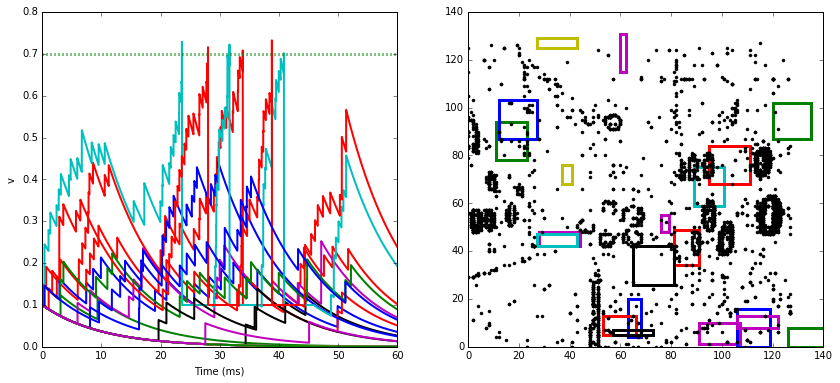

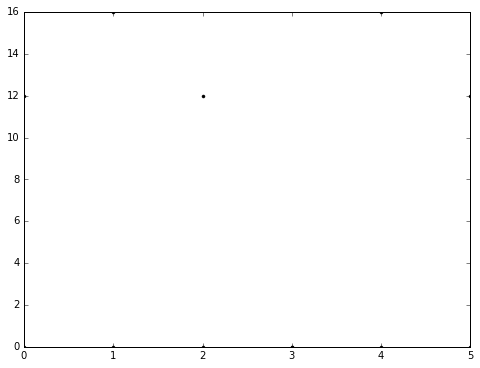

In [29]:
start_scope()

defaultclock.dt = 1*us
RESX = 128
RESY = 128
RES = RESX * RESY
N = 20                           # We will have 4 neurons       
tau = 10*ms
eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''
flatIndex = lambda x, y : y*RESX + x
squareIndex = lambda i : (i % 128, int(i / 128))  # TODO there is probably some math todo for DAVIS 

## LOAD REAL DATA
file = 'M1a_expand.aedat'
bytes2read = 30000
ts, xs, ys, ps = loadaerdat(datafile=file, length=bytes2read, version='aedat', debug=0, camera='DVS128')
# TODO This means no 2 distinct neurons can fire at the same us.... Needs a fix
real_indices = [flatIndex(*xy) for xy in zip(xs, ys)]
real_times, uniq_idxs = np.unique(ts, return_index=True)
real_indices = np.asarray(real_indices)[uniq_idxs]
real_times = (real_times - real_times[0])*us
inp = SpikeGeneratorGroup(RES, real_indices, real_times)
G = NeuronGroup(N, eqs, threshold='v>0.7', reset='v=0.1', method='linear', refractory=5*ms)
S = Synapses(inp, G, 'w : 1', on_pre='v_post += w')


# And we will generate a recField for each neuron
minx, miny, maxx, maxy = (1, 1, 16, 16)

rcxs = np.clip(np.random.normal(maxx - minx, (maxx - minx)/2, N).astype(int), minx, maxx)
rcys = np.clip(np.random.normal(maxy - miny, (maxy - miny)/2, N).astype(int), miny, maxy)
rcsizes = list(zip(rcxs, rcys))

locs = list(zip(np.random.uniform(0, RESX-1, N).astype(int), np.random.uniform(0, RESY-1, N).astype(int)))

# Set up fields for all neurons
#locs = [(10, 10),       # quiet region
#        (0, 45),        # Left side, middle
#        (82, 20),       # medium busy region
#        (50, 40)]    
for n in range(N):
    S.connect(i=np.array(rec_field(*(locs[n]), *(rcsizes[n]))), j=n)  
    
S.w = 0.05
G.v = 0.1

voltMon = StateMonitor(G, 'v', record=True)
spikesMon_opt = SpikeMonitor(G)

###############      RUN AND PLOT    ###############
run(60*ms)

figure(figsize=(14, 6))
subplot(121)
colours = ['r', 'g', 'b', 'm', 'c', 'm', 'y', 'k']
for n in range(N):
    plot(voltMon.t/ms, voltMon.v[n], '-'+colours[n%len(colours)], lw=2, label='N'+str(n))
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
#legend(loc='best')

# Plot image and RC locations
ax = subplot(122)
plot(xs, ys, '.k')
for n in range(N):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=colours[n%len(colours)], fill=False))
    
figure(figsize=(8,6))
hid_spikes = spikesMon_opt.i

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
#spiked = [squareIndex(x) for x in spikesMon_opt.i]
#plot(spiked, '.k')
#print(spiked)


In [27]:
help(SpikeMonitor)

Help on class SpikeMonitor in module brian2.monitors.spikemonitor:

class SpikeMonitor(EventMonitor)
 |  Record spikes from a `NeuronGroup` or other spike source.
 |  
 |  The recorded spikes can be accessed in various ways (see Examples below):
 |  the attributes `~SpikeMonitor.i` and `~SpikeMonitor.t` store all the indices
 |  and spike times, respectively. Alternatively, you can get a dictionary
 |  mapping neuron indices to spike trains, by calling the `spike_trains`
 |  method. If you record additional variables with the ``variables`` argument,
 |  these variables can be accessed by their name (see Examples).
 |  
 |  Parameters
 |  ----------
 |  source : (`NeuronGroup`, `SpikeSource`)
 |      The source of spikes to record.
 |  variables : str or sequence of str, optional
 |      Which variables to record at the time of the spike (in addition to the
 |      index of the neuron). Can be the name of a variable or a list of names.
 |  record : bool, optional
 |      Whether or not 

Randomly generating receptive fields for neurons seems to be working well. Now lets combine some early work and make these neurons more detailed, add in some stochastic noise and an adaptive threshold. 

file size 30000


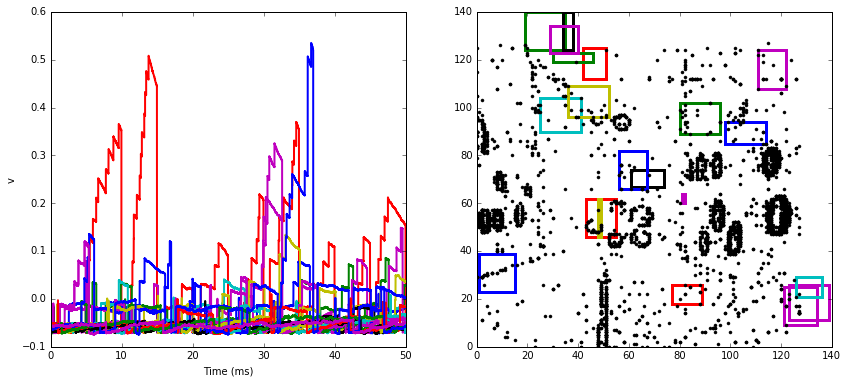

In [20]:
start_scope()

defaultclock.dt = 1*us
RESX = 128
RESY = 128
RES = RESX * RESY
N = 20                           # We will have 4 neurons       
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
eqs = '''
dv/dt = (v_drive + vr - v) / tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0 - vt) / tau_t : volt
'''
reset = '''
v = vr
vt += delta_vt0
'''
flatIndex = lambda x, y : y*RESX + x
squareIndex = lambda i : (i % 128, int(i / 128))  # TODO there is probably some math todo for DAVIS 

## LOAD REAL DATA
file = 'M1a_expand.aedat'
bytes2read = 30000
ts, xs, ys, ps = loadaerdat(datafile=file, length=bytes2read, version='aedat', debug=0, camera='DVS128')
# TODO This means no 2 distinct neurons can fire at the same us.... Needs a fix
real_indices = [flatIndex(*xy) for xy in zip(xs, ys)]
real_times, uniq_idxs = np.unique(ts, return_index=True)
real_indices = np.asarray(real_indices)[uniq_idxs]
real_times = (real_times - real_times[0])*us
inp = SpikeGeneratorGroup(RES, real_indices, real_times)
G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, method='euler', refractory=5*ms)
S = Synapses(inp, G, 'w : volt', on_pre='v_post += w')


# And we will generate a recField for each neuron
minx, miny, maxx, maxy = (1, 1, 16, 16)

rcxs = np.clip(np.random.normal(maxx - minx, (maxx - minx)/2, N).astype(int), minx, maxx)
rcys = np.clip(np.random.normal(maxy - miny, (maxy - miny)/2, N).astype(int), miny, maxy)
rcsizes = list(zip(rcxs, rcys))

locs = list(zip(np.random.uniform(0, RESX-1, N).astype(int), np.random.uniform(0, RESY-1, N).astype(int)))

# Set up fields for all neurons
#locs = [(10, 10),       # quiet region
#        (0, 45),        # Left side, middle
#        (82, 20),       # medium busy region
#        (50, 40)]    
for n in range(N):
    S.connect(i=np.array(rec_field(*(locs[n]), *(rcsizes[n]))), j=n)  
    
S.w = 0.05*volt
G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

voltMon = StateMonitor(G, 'v', record=True)

###############      RUN AND PLOT    ###############
run(50*ms)

figure(figsize=(14, 6))
subplot(121)
colours = ['r', 'g', 'b', 'm', 'c', 'm', 'y', 'k']
for n in range(N):
    plot(voltMon.t/ms, voltMon.v[n], '-'+colours[n%len(colours)], lw=2, label='N'+str(n))
    
#axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
#legend(loc='best')

# Plot image and RC locations
ax = subplot(122)
plot(xs, ys, '.k')
for n in range(N):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=colours[n%len(colours)], fill=False))


Network may be suffering from some areas being too active while others are quiet so a global threshold is hard.. Appropriate weights would help but then a learning rule for these would be needed. Or I could use hardcoded values but again then threshold needs to be appropriate etc. 

Now lets define an autoencoding network. The network will have 128*128 input neurons, a variable number of middle layer neurons and 128*128 output neurons. 

In [26]:
start_scope()

defaultclock.dt = 1*us
RESX = 128
RESY = 128
RES = RESX * RESY
N = 20                           # We will have 4 neurons       
tau = 10*ms
taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

eqs = '''
dv/dt = (I - v) / tau : 1 (unless refractory)  # Pick any model
I = 0: 1
'''
flatIndex = lambda x, y : y*RESX + x
squareIndex = lambda i : (i % 128, int(i / 128))  # TODO there is probably some math todo for DAVIS 

## LOAD REAL DATA
file = 'M1a_expand.aedat'
bytes2read = 30000
ts, xs, ys, ps = loadaerdat(datafile=file, length=bytes2read, version='aedat', debug=0, camera='DVS128')
# TODO This means no 2 distinct neurons can fire at the same us.... Needs a fix
real_indices = [flatIndex(*xy) for xy in zip(xs, ys)]
real_times, uniq_idxs = np.unique(ts, return_index=True)
real_indices = np.asarray(real_indices)[uniq_idxs]
real_times = (real_times - real_times[0])*us
inp = SpikeGeneratorGroup(RES, real_indices, real_times)
otp = SpikeGeneratorGroup(RES, real_indices, real_times + 5*ms)
hid = NeuronGroup(N, eqs, threshold='t>(1+i)*20*ms + 5*ms', reset='v=0.0', method='linear', refractory=5*ms)
S_hid = Synapses(inp, hid,              '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
S_otp = Synapses(hid, otp,              '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')


# And we will generate a recField for each neuron
minx, miny, maxx, maxy = (1, 1, 16, 16)

rcxs = np.clip(np.random.normal(maxx - minx, (maxx - minx)/2, N).astype(int), minx, maxx)
rcys = np.clip(np.random.normal(maxy - miny, (maxy - miny)/2, N).astype(int), miny, maxy)
rcsizes = list(zip(rcxs, rcys))

locs = list(zip(np.random.uniform(0, RESX-1, N).astype(int), np.random.uniform(0, RESY-1, N).astype(int)))

# Set up fields for all neurons
#locs = [(10, 10),       # quiet region
#        (0, 45),        # Left side, middle
#        (82, 20),       # medium busy region
#        (50, 40)]    
for n in range(N):
    S_hid.connect(i=np.array(rec_field(*(locs[n]), *(rcsizes[n]))), j=n)  
    S_otp.connect(i=n, j=np.array(rec_field(*(locs[n]), *(rcsizes[n]))))
    
S_hid.w = 0.05
hid.v = 0.1

voltMon = StateMonitor(hid, 'v', record=True)

###############      RUN AND PLOT    ###############
run(60*ms)

figure(figsize=(14, 6))
subplot(121)
colours = ['r', 'g', 'b', 'm', 'c', 'm', 'y', 'k']
for n in range(N):
    plot(voltMon.t/ms, voltMon.v[n], '-'+colours[n%len(colours)], lw=2, label='N'+str(n))
    
axhline(0.7, ls=':', c='g', lw=3)  # Threshold line
xlabel('Time (ms)')
ylabel('v')
#legend(loc='best')

# Plot image and RC locations
ax = subplot(122)
plot(xs, ys, '.k')
for n in range(N):
    ax.add_patch(Rectangle(locs[n], *(rcsizes[n]), lw=3, color=colours[n%len(colours)], fill=False))


file size 30000


BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/core/network.py", line 688, in before_run
    obj.before_run(run_namespace)
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/core/base.py", line 278, in device_override_decorated_function
    return func(*args, **kwds)
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/synapses/synapses.py", line 268, in before_run
    CodeRunner.before_run(self, run_namespace)
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/groups/group.py", line 1091, in before_run
    codeobj_class=self.codeobj_class
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/codegen/codeobject.py", line 225, in create_runner_codeobj
    _, uk, u = analyse_identifiers(v, all_variables, recursive=True)
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/codegen/translation.py", line 97, in analyse_identifiers
    scalar_stmts, vector_stmts = make_statements(code, variables, np.float64, optimise=False)
  File "/usr/local/anaconda3/lib/python3.5/site-packages/brian2/codegen/translation.py", line 265, in make_statements
    dtype=variables[var].dtype,
KeyError: 'v_post'

Error encountered with object named "synapses_2_pre".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-26-f1dd116e3c1e>", line 60, in <module>
    ''')

An error occurred when preparing an object. KeyError: 'v_post'
(See above for original error message and traceback.)